# Introduction

This notebook records a program that I have built that compute the Sharpe optimal portfolio given a set of securities.

### Package Imports

In [1]:
import scipy.optimize as sco
import scipy.stats as scs
import numpy as np
import pandas as pd

import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Let's say a person would like to invest in the asset classes listed below. However, he does not know how much to allocate his capital in each of these asset classes. I have designed a program that takes in a series of securities, and outputs the Sharpe optimal risky portfolio composing those securities. 

| Asset Classes                         |  ETFS  |% of risky portfolio | 
|------------------------------------|----|------------------|
| Global Listed Property             |  DJRE.AX  |  ? %         |
| Australian Equities                |  STW.AX  |  ? %         |
| Intl Equities (Unhedged)           |  VGS.AX  |  ? %         |
| Intl Equities (Hedged)             |   VGAD.AX |  ? %         |
| Global Infrastructure              |  IFRA.AX  |  ? %         |
| Bond/Fixed Income                  |  IAF.AX  |  ?  %         |
|**Total**                           |    |  100%         |

In [9]:
ticker_list = ['DJRE.AX', 'STW.AX', 'VGS.AX', 'VGAD.AX', 'IFRA.AX', 'IAF.AX', 'AAA.AX']

# initialise an empty list, where each element will store a dataframe (table) with the data for a stock
df_list = []

# for each stock, download daily data for the stated date range and append it to our list
for ticker in ticker_list:
    data = yf.download(ticker, start="2018-07-01", end="2021-09-30", group_by="Ticker", period='1d') # download data for a stock
    data['ticker'] = ticker  # add a new column with the stock's ticker
    df_list.append(data) # append the dataframe to our list

# combine all dataframes into a single dataframe
df = pd.concat(df_list)

df = df.filter(items = ['Adj Close','ticker'])

#pivot the df such that there is one column per stock
df = df.pivot(columns='ticker')

#reformat the df column headings to look neater
df.columns = [col[1] for col in df.columns]

#create a returns dataframe
returns = df.pct_change()

returns = returns.dropna()
returns


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,AAA.AX,DJRE.AX,IAF.AX,IFRA.AX,STW.AX,VGAD.AX,VGS.AX
Date,,,,,,,
2018-07-03,0.0002,-0.000474,-0.000375,0.006781,0.004839,0.005111,0.009099
2018-07-04,0.0002,0.000948,0.001971,0.004663,-0.004128,-0.001541,-0.005527
2018-07-05,-0.0002,0.007102,-0.000562,-0.001031,0.004836,-0.000617,0.003217
2018-07-06,0.0002,0.004231,-0.002250,0.006711,0.009282,0.009111,0.004082
2018-07-09,0.0000,-0.002809,0.001033,0.008718,0.001362,0.008416,0.002613
...,...,...,...,...,...,...,...
2021-09-23,0.0000,0.007624,-0.000175,-0.000942,0.010641,0.009689,0.011184
2021-09-24,0.0000,-0.010088,-0.007700,-0.004715,-0.004471,0.007197,-0.000098
2021-09-27,0.0000,-0.000849,0.000176,-0.001421,0.006375,0.004196,0.006460


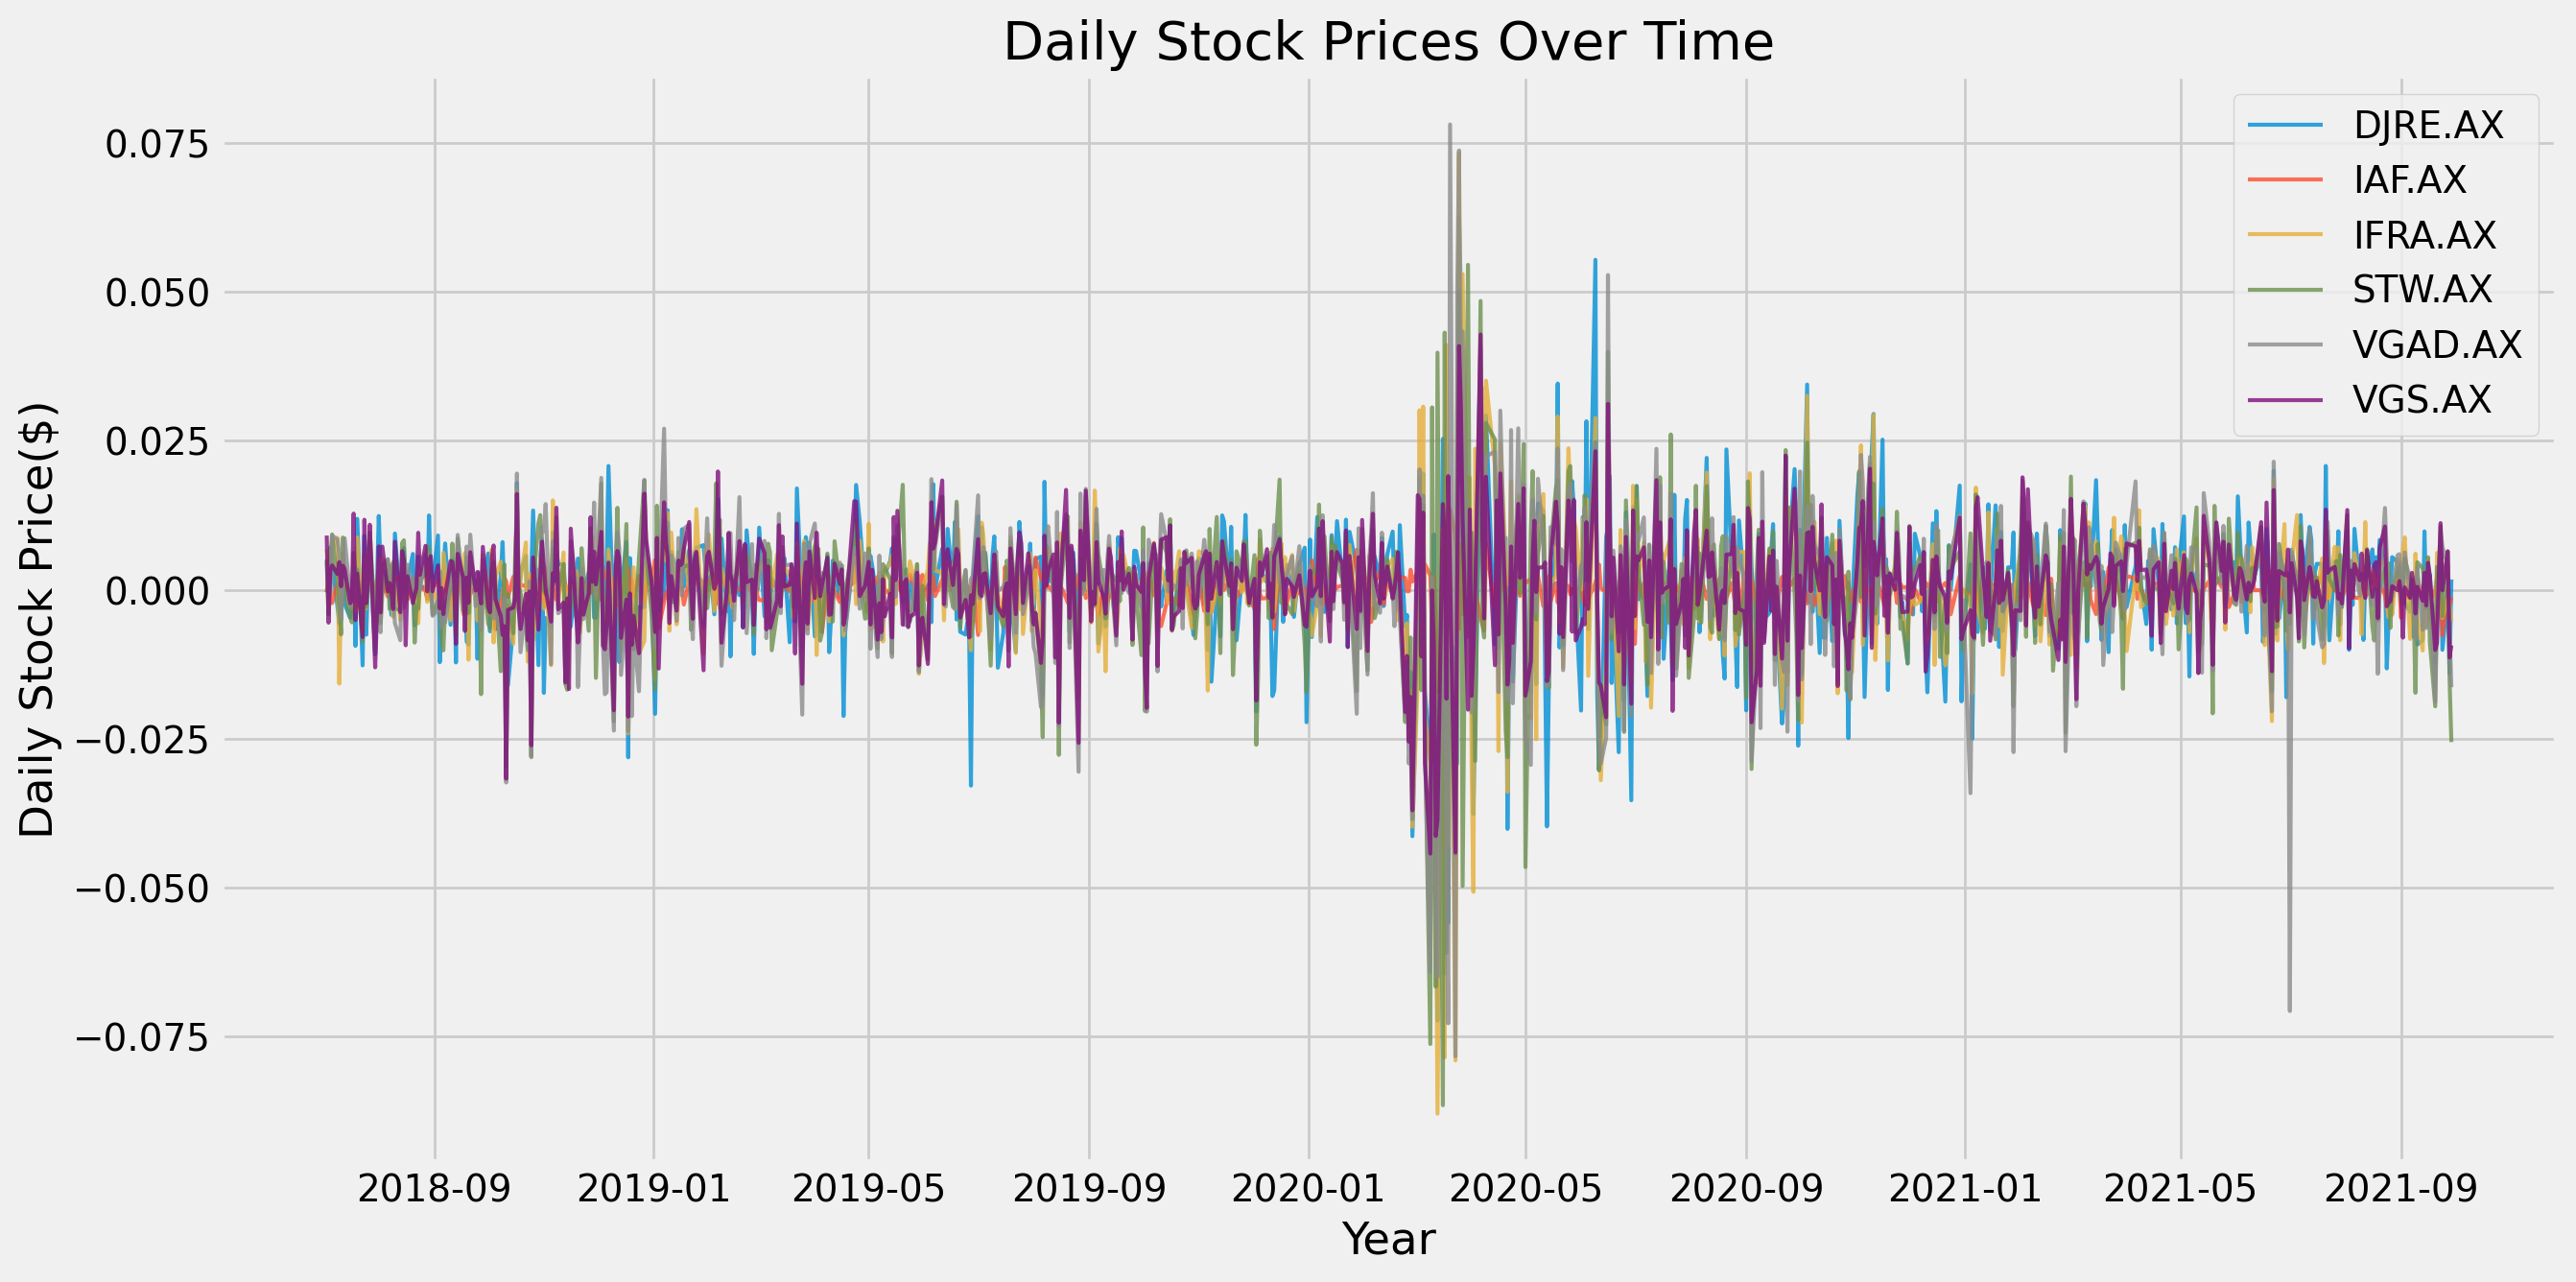

In [10]:
risk_free_rate = returns['AAA.AX'].mean() *252

returns = returns.drop("AAA.AX", axis=1)

mean_returns = returns.mean()
cov_matrix = returns.cov()

# plot the return time series
plt.figure(figsize=(14,7))
plt.plot(returns, lw=1.5, alpha=0.8)

plt.xlabel("Year")
plt.ylabel("Daily Stock Price($)")
plt.title("Daily Stock Prices Over Time")
plt.legend(returns)

1. Finds the <b>Sharpe-optimal risky portfolio</b> given a set of securities (those we've looked at above, but can be anything really)
1. Compute and plot the efficient frontier. Plots are appropriately labelled and a minimum of 7\% is invested into each ETF.
1. Shows the asset allocation of the Sharpe-optimal risky portfolio.
1. Create a variable called `optimal_allocation`. It should be a dictionary which stores {ticker: weight}, i.e., ticker names as keys and their corresponding weights in the sharpe optimal portfolio, rounded to 3 decimal places, as values.

In [26]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    '''
    portfolio performance evaluation function

    :weights: stock weights (array of floats)
    :mean_returns: mean stock returns (series of floats)
    :cov_matrix: stock covariances (df of floats)

    :return: annualised standard deviation and returns of a portfolio (both float)
    '''
    # calculate annualised mean portfolio return 
    returns = np.sum(mean_returns * weights ) * 252 
    
    # calculate annualised portfolio standard deviation
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) 
    
    #return annual standard deviation and return of the portfolio (both scalars)
    return std, returns

# # find number of assets
num_assets = len(mean_returns)
# # create a list of weights
# equal_weights = [1/num_assets for asset in mean_returns]
# # make our list a vector
# equal_weights = np.array(equal_weights)

def portfolio_volatility(weights, mean_returns, cov_matrix):
    '''
    function to compute portfolio volatility. we will need this for our optimisation function later, 
    as that requires a function that only gives one output (std deviation) rather than two 
    (std dev and returns, as in the previous function)

    :weights: stock weights (array of floats)
    :mean_returns: mean stock returns (series of floats)
    :cov_matrix: stock covariances (df of floats)

    :return: annualised standard deviation of a portfolio (float)
    '''
    # call the portfolio_annualised_performance function, but return only the std dev. 
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def portfolio_return(weights, mean_returns, cov_matrix):
    '''
    function to compute portfolio return. we will need this for our optimisation function later, 
    as that requires a function that only gives one output (portfolio returns) rather than two 
    (std dev and returns, as in the previous function)

    :weights: stock weights (array of floats)
    :mean_returns: mean stock returns (series of floats)
    :cov_matrix: stock covariances (df of floats)

    :return: annualised return of a portfolio (float)
    '''
    # call the portfolio_annualised_performance function, but return only the portfolio returns. 
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate): 
    '''
    function to compute negative Sharp ratio

    :weights: stock weights (array of floats)
    :mean_returns: mean stock returns (series of floats)
    :cov_matrix: stock covariances (df of floats)
    :risk_free_rate: annual risk-free rate (float)

    :return: negative sharpe ratio for a portfolio (float)
    '''
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    '''
    function to compute maximum Sharpe ratio portfolio weights using optimisation

    :mean_returns: mean stock returns (series of floats)
    :cov_matrix: stock covariances (df of floats)
    :risk_free_rate: risk-free rate (float)

    :return: attribute dictionary with the optimisation result, including portfolio weights of the maximum 
    sharpe ratio portfolio 
    '''
    arguments = (mean_returns, cov_matrix, risk_free_rate)
    equation_constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    #set weight constaints i.e. must be between 0 and 1 (inclusive), so no short selling
    weight_constraint = [0.07, 1]
    #apply this constraint to each asset using list comprehension 
    weight_constraints = [weight_constraint for asset in mean_returns]
    
    initial_guess = [1/num_assets for asset in mean_returns]
    
    max_sharpe_weights = sco.minimize(neg_sharpe_ratio, initial_guess, args=arguments,
                        method='SLSQP', bounds=weight_constraints, constraints=equation_constraints)
    
    return max_sharpe_weights

opt_weight = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate).x

optimal_allocation = {}
for count, ticker in enumerate(returns.columns):
     optimal_allocation[ticker] = round(opt_weight[count], 3)

print("Asset allocation of the Sharpe-optimal risky portfolio, as a percentage of portfolio: ")
print(optimal_allocation)

std_opt = round(portfolio_volatility(opt_weight, mean_returns, cov_matrix), 4)

return_opt = round(portfolio_return(opt_weight, mean_returns, cov_matrix), 4)
sharpe_opt = round(-neg_sharpe_ratio(opt_weight, mean_returns, cov_matrix, risk_free_rate), 4)

print('Annual standard deviation: ', std_opt)
print('Annual return: ', return_opt)
print('Sharpe ratio: ', sharpe_opt)

Asset allocation of the Sharpe-optimal risky portfolio, as a percentage of portfolio: 
{'DJRE.AX': 0.07, 'IAF.AX': 0.167, 'IFRA.AX': 0.07, 'STW.AX': 0.07, 'VGAD.AX': 0.07, 'VGS.AX': 0.553}
Annual standard deviation:  0.1129
Annual return:  0.0924
Sharpe ratio:  0.8183


| Asset Classes                         |  ETFS  |% of risky portfolio | 
|------------------------------------|----|------------------|
| Global Listed Property             |  DJRE.AX  |  7%         |
| Australian Equities                |  STW.AX  |  7%         |
| Intl Equities (Unhedged)           |  VGS.AX  |  55.3%         |
| Intl Equities (Hedged)             |   VGAD.AX |  7%         |
| Global Infrastructure              |  IFRA.AX  |  7%         |
| Bond/Fixed Income                  |  IAF.AX  |  16.7%         |
|**Total**                           |    |  100%         |

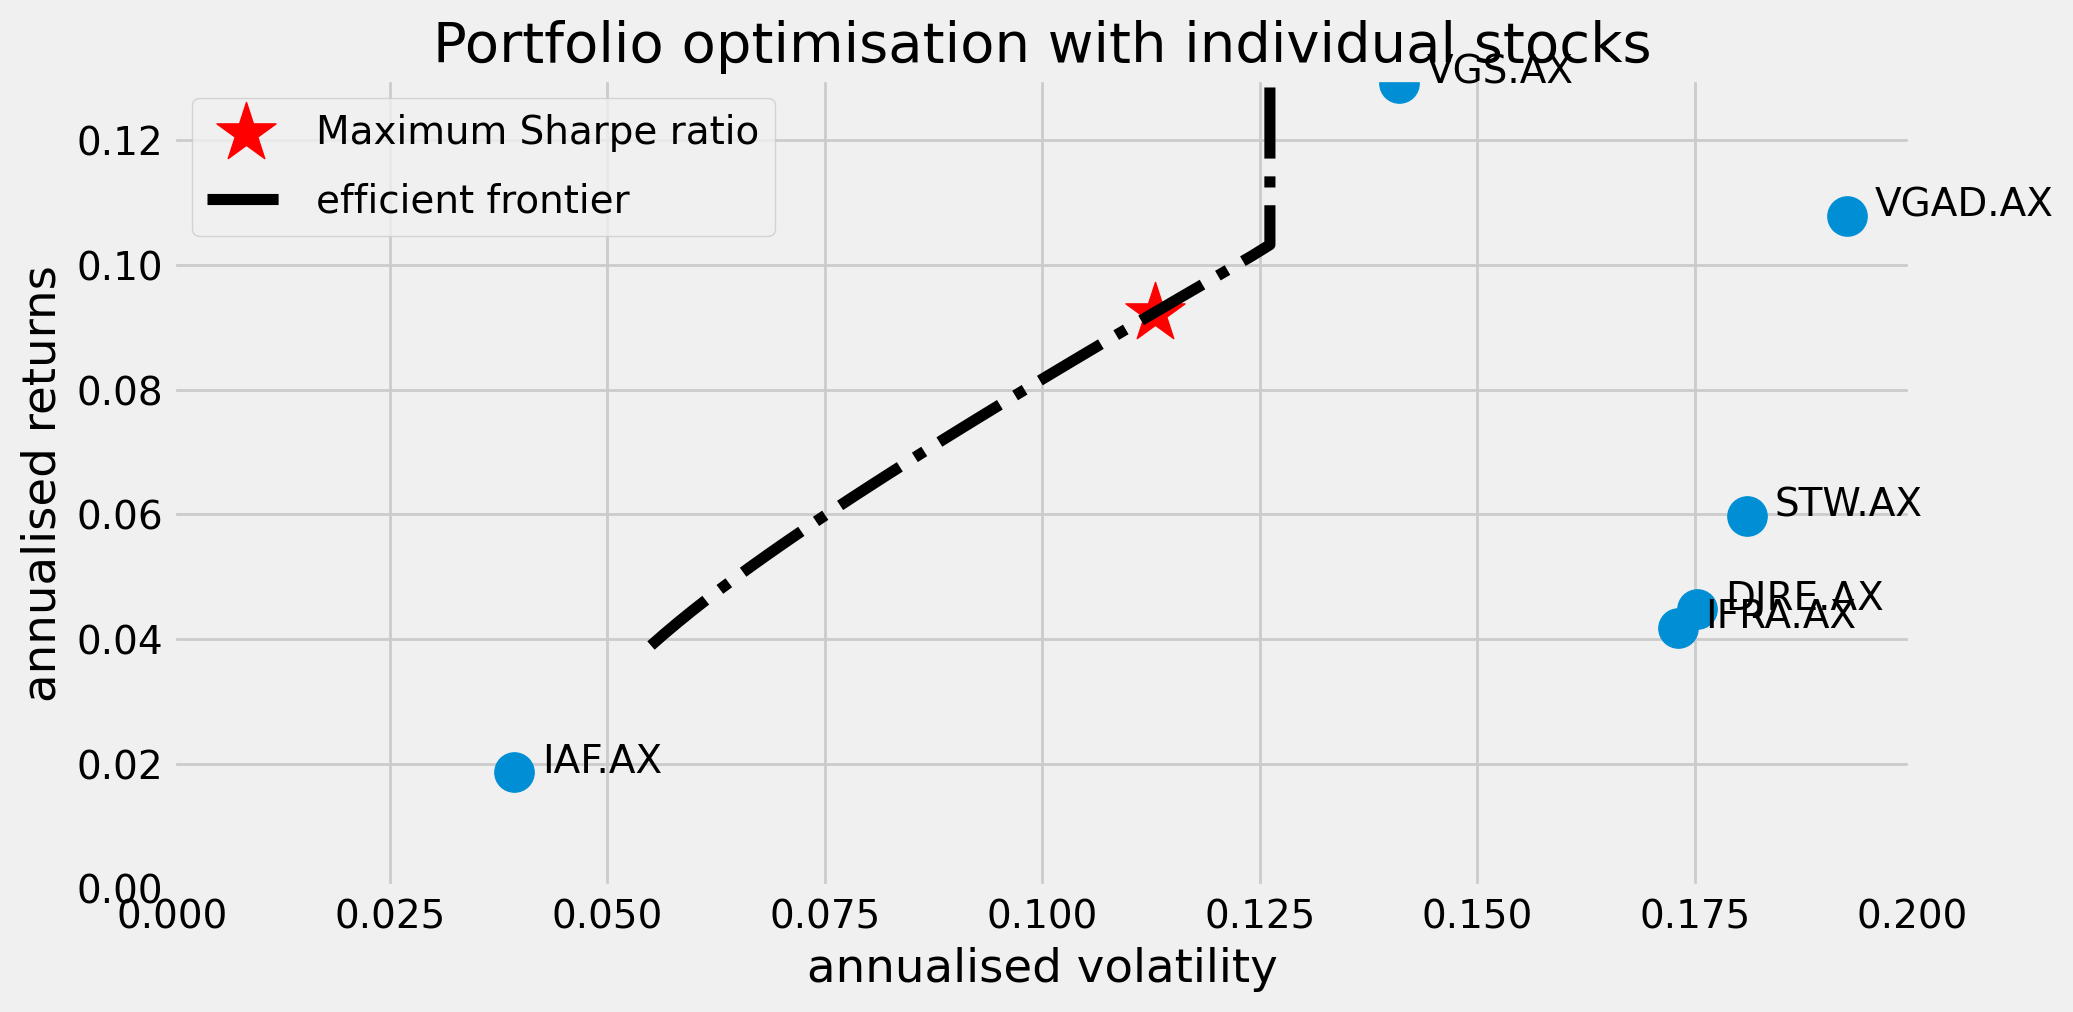

In [27]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    # calculate annualised mean portfolio return 
    returns = np.sum(mean_returns * weights ) * 252 
    # calculate annualised portfolio standard deviation
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) 
    #return annual standard deviation and return of the portfolio (both scalars)
    return std, returns

def portfolio_volatility(weights, mean_returns, cov_matrix):
    # call the portfolio_annualised_performance function, but return only the portfolio std dev. 
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def portfolio_return(weights, mean_returns, cov_matrix):
    # call the portfolio_annualised_performance function, but return only the portfolio returns. 
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate): 
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def min_variance(mean_returns, cov_matrix):

    arguments = (mean_returns, cov_matrix)
    equation_constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    num_assets = len(mean_returns)
    # new constraint (min. bound, upper bound)
    weight_constraint = [0.07, np.inf]
    # apply this constraint to each asset using list comprehension 
    weight_constraints = [weight_constraint for asset in range(num_assets)]
    initial_guess = [1/num_assets for asset in mean_returns]
    # adding an extra argument for our bounds
    min_var_weights = sco.minimize(portfolio_volatility, initial_guess, args=arguments,
                        method='SLSQP', bounds=weight_constraints, constraints=equation_constraints)
    return min_var_weights

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
        
    arguments = (mean_returns, cov_matrix, risk_free_rate)  
    equation_constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) 
    num_assets = len(mean_returns) 
    weight_constraint = [0.07, np.inf] 
    weight_constraints = [weight_constraint for asset in range(num_assets)] 
    initial_guess = [1/num_assets for asset in mean_returns]  
    max_sharpe_weights = sco.minimize(neg_sharpe_ratio, initial_guess, args=arguments,
                        method='SLSQP', constraints=equation_constraints, bounds=weight_constraints)
    return max_sharpe_weights

def efficient_return(mean_returns, cov_matrix, target):

    arguments = (mean_returns, cov_matrix)
    equation_constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x, mean_returns, cov_matrix) - target},
                           {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    num_assets = len(mean_returns)
    weight_constraint = [0.07, np.inf]
    weight_constraints = [weight_constraint for asset in range(num_assets)]
    initial_guess = [1/num_assets for asset in mean_returns]
    efficient_return_weights = sco.minimize(portfolio_volatility, initial_guess, args=arguments, method='SLSQP', 
                          constraints=equation_constraints, bounds=weight_constraints)
    return efficient_return_weights

def efficient_frontier(mean_returns, cov_matrix, returns_range): 
    efficient_weights = []
    for target_returns in returns_range:
        efficient_weights.append(efficient_return(mean_returns, cov_matrix, target_returns))
    return efficient_weights

def display_calculated_ef(mean_returns, cov_matrix, risk_free_rate):
    
    # compute the maximum Sharpe ratio portfolio
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    # compute the returns and standard deviation of the sharpe optimal portfolio
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    # create a dataframe to store the allocations of stocks in the Sharpe optimal portfolio
    max_sharpe_allocation = pd.DataFrame(max_sharpe['x'],index=returns.columns,columns=['allocation'])
    # convert the stock weights from decimal to percentage and round the % weights to 3 decimal places 
    max_sharpe_allocation.allocation = [round(i * 100, 3) for i in max_sharpe_allocation.allocation]
    # transpose the index and column, i.e., index is now the allocation and column is the now stock names
    max_sharpe_allocation = max_sharpe_allocation.T
    
    # compute the minimum variance portfolio
    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol['x'],index=returns.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i * 100, 3) for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T  
    
    # compute the annualised volatility (standard deviation) and mean return of individual stocks
    an_vol = pd.Series([np.sqrt(i) * np.sqrt(252) for i in np.diag(cov_matrix)], index=mean_returns.index)
    an_rt = mean_returns * 252
    
    # display the summary statistics (mean and standard deviation) of the minimum variance portfolio, 
    # the Sharpe optimal portfolio and individual stocks (rounded to 3 decimal places)
    
    # Sharpe optimal portfolio
#     print("-" * 80)
#     print("Maximum Sharpe ratio portfolio allocation\n")
#     print("Annualised return:", round(rp, 3))
#     print("Annualised volatility:", round(sdp, 3))
#     print("\n")
#     print(max_sharpe_allocation)
    
#     # Individual stocks' annualised returns and volatility
#     print("-"*80)
#     print("Individual stock returns and volatility\n")
#     for i, txt in enumerate(returns.columns):
#         print("%s: annualised return: %0.3f, annualised volatility: %0.3f" % \
#               (txt, round(an_rt[i], 3), round(an_vol[i], 3)))
#     print("-"*80)

    # generate plot of optimal portfolios
    # set the plot size 
    fig, ax = plt.subplots(figsize=(10, 5))  
    
    # use a scatter plot to plot individaul stocks' annualised return and volatility
    ax.scatter(an_vol,an_rt,marker='o',s=200)
    # label the individual stocks on the graph
    for i, txt in enumerate(returns.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
        
    # plot the Sharpe optimal portfolio on the graph
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')    
    
    # compute the efficient frontier for each target return  
    target = np.linspace(rp_min, 0.129, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    
    # plot efficient froniter
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    
    # set axes limits, label the plot and axes, include a legend
    plt.ylim(0, 0.13)
    plt.xlim(0, 0.20)
    ax.set_title('Portfolio optimisation with individual stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)
    
display_calculated_ef(mean_returns, cov_matrix, risk_free_rate)